# 主題 02-1. 用 CNN 做圖形辨識

Yann LeCun 被譽為 Deep Learning 的三巨頭之一。他的 CNN (Convolutional Neural Networks) 是讓 Neural Network 重新受到重視的主因之一。

## 1. 初始準備

基本上和之前是一樣的, 我們就不再說明。

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 2. 讀入 MNIST 數據庫

### 2.1 由 Keras 讀入 MNIST

基本上和我們上次一樣, 這次因為 Keras 已偷偷把數據庫存在你的電腦, 所以會快很多!

In [3]:
from keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


### 2.2 輸入格式整理

如果你還記得, 我們每筆輸入資料都是 28x28 的陣列, CNN 其實就是吃「圖」的, 所以基本上不用像之前把每筆資料拉平。「但。是。」平常的圖都有 R, G, B 三個 channels, 每個 channel 都是一個矩陣, 也就是一張圖可能是三個矩陣! 我們是灰階, 也就是只有一個 channel。但這件事也要明確的告訴 Keras。

換句話說, 我們的輸入每筆資料型式要從 (28, 28) 換成 (28, 28, 1)!

In [5]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

確認一下...

In [6]:
x_train[9487].shape

(28, 28, 1)

原來 28x28 矩陣...

In [7]:
x_train[9487][:,:,0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240,
        253, 165,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 241,
        252, 252,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

### 2.3 輸出格式整理

和上次一樣, 我們用標準 1-hot 方式處理。

In [8]:
from keras.utils import np_utils

In [9]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

## 3. 打造你的 CNN

### 3.1 決定神經網路架構、讀入相關套件

CNN 我們一樣要決定用幾層的 CNN, 然後是不是每次都要做 max-pooling。再來就是拉平、送入標準神經網路 (再度要決定幾層、幾個神經元)。

* 做 <span style="color:red;">3</span> 次 convolution, 每次都接 max-pooling
* filter 大小都是 <span style="color:red;">3x3</span>, max-pooling 都用 <span style="color:red;">2x2</span> 為一小區塊

CNN 一個小技巧是每層的 filters 數目是越來越多。做完 convolution 之後, 我們要拉平、再送入一個標準的神經網路。這個神經網路設計是這樣:

* 只有 <span style="color:red;">1</span> 個隱藏層, 使用 <span style="color:red;">200</span> 個神經元。

In [15]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.8.2


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

### 3.2 建構我們的神經網路

一開始一樣是打開個空白的神經網路。

In [18]:
model = Sequential()

第一個隱藏層一樣要告訴 Keras 我們輸入長什麼樣子。`padding` 設成 `same` 是每個 filter 會輸出原來 28x28 一樣大小的矩陣。

In [19]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))

Max-Pooling!

In [20]:
model.add(MaxPooling2D(pool_size=(2, 2)))

第二次 Convolution!

In [21]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

再 Max-Pooling!

In [22]:
model.add(MaxPooling2D(pool_size=(2, 2)))

第三次 Convolution!

In [23]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

Max-Pooling 最終回。

In [24]:
model.add(MaxPooling2D(pool_size=(2, 2)))

然後我們要送進一般的神經網路了。記得這是要拉平的, 還在 Keras 會幫我們做!

In [25]:
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))

輸出和上次一樣!

In [26]:
model.add(Dense(10))
model.add(Activation('softmax'))

### 3.3 組裝

和之前比較不一樣的是我們還要做 `compile` 才正式把我們的神經網路建好。

In [ ]:
#model.compile(loss="categorical_crossentropy",
#              optimizer=Adadelta(),
#              metrics=['accuracy'])

In [27]:
model.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 3.4 檢視我們的神經網路

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

## 4. 訓練

In [29]:
model.fit(x_train, y_train, batch_size=100, epochs=12)

Epoch 1/12
600/600 [==============================] - 89s 147ms/step - loss: 0.0891 - accuracy: 0.5159
Epoch 2/12
600/600 [==============================] - 89s 148ms/step - loss: 0.0058 - accuracy: 0.9613
Epoch 3/12
600/600 [==============================] - 89s 148ms/step - loss: 0.0038 - accuracy: 0.9754
Epoch 4/12
600/600 [==============================] - 88s 146ms/step - loss: 0.0029 - accuracy: 0.9815
Epoch 5/12
600/600 [==============================] - 89s 148ms/step - loss: 0.0024 - accuracy: 0.9846
Epoch 6/12
600/600 [==============================] - 90s 149ms/step - loss: 0.0020 - accuracy: 0.9876
Epoch 7/12
600/600 [==============================] - 89s 148ms/step - loss: 0.0017 - accuracy: 0.9896
Epoch 8/12
600/600 [==============================] - 90s 150ms/step - loss: 0.0015 - accuracy: 0.9911
Epoch 9/12
600/600 [==============================] - 89s 149ms/step - loss: 0.0012 - accuracy: 0.9930
Epoch 10/12
600/600 [==============================] - 89s 148ms/step - l

## 5. 結果測試

### 5.1 分數

In [30]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 10s 31ms/step - loss: 0.0024 - accuracy: 0.9848


In [31]:
print('測試資料的 loss:', score[0])
print('測試資料正確率:', score[1])

測試資料的 loss: 0.0024271165020763874
測試資料正確率: 0.9847999811172485


### 5.2 儲存結果

結果看來還不差, 所以我們把結果存起來。

In [32]:
model_json = model.to_json()
open('handwriting_model_cnn.json', 'w').write(model_json)
model.save_weights('handwriting_weights_cnn.h5')

### 5.3 欣賞一下成果

我們用另一個方式: 每次選 5 個顯示, 看是不是有正確辨識。

In [34]:
#predict = model.predict_classes(x_test)
predict = (model.predict(x_test) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


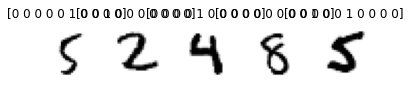

In [35]:
pick = np.random.randint(1,9999, 5)

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[pick[i]].reshape(28,28), cmap='Greys')
    plt.title(predict[pick[i]])
    plt.axis("off")

## 5.4 小結論

我們到此, 基本上是「亂做」的神經網路。有些同學在不斷試驗的過程中, 可能會發現有時會出現很糟糕的結果。因此, 接下來我們要介紹怎麼樣用些簡單的手法, 能讓學習效果比較穩定, 而且有可能可以增加學習效率。